#  Lire des données depuis s3



<a href="https://github.com/linogaliana/python-datascientist/blob/master//__w/python-datascientist/python-datascientist/notebooks/course/manipulation/05a_s3.ipynb" class="github"><i class="fab fa-github"></i></a>
[![Download](https://img.shields.io/badge/Download-Notebook-important?logo=Jupyter)](https://downgit.github.io/#/home?url=https://github.com/linogaliana/python-datascientist/blob/master//__w/python-datascientist/python-datascientist/notebooks/course/manipulation/05a_s3.ipynb)
[![nbviewer](https://img.shields.io/badge/Visualize-nbviewer-blue?logo=Jupyter)](https://nbviewer.jupyter.org/github/linogaliana/python-datascientist/blob/master//__w/python-datascientist/python-datascientist/notebooks/course/manipulation/05a_s3.ipynb)
[![Onyxia](https://img.shields.io/badge/SSPcloud-Tester%20via%20SSP--cloud-informational&color=yellow?logo=Python)](https://datalab.sspcloud.fr/launcher/inseefrlab-helm-charts-datascience/jupyter?onyxia.friendlyName=«python-datascientist»&resources.requests.memory=«4Gi»&security.allowlist.enabled=false&init.personalInit=«https://raw.githubusercontent.com/linogaliana/python-datascientist/master/init_onyxia.sh»)
[![Binder](https://img.shields.io/badge/Launch-Binder-E66581.svg?logo=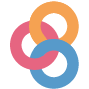)](https://mybinder.org/v2/gh/linogaliana/python-datascientist/master?filepath=/__w/python-datascientist/python-datascientist/notebooks/course/manipulation/05a_s3.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](http://colab.research.google.com/github/linogaliana/python-datascientist/blob/master//__w/python-datascientist/python-datascientist/notebooks/course/manipulation/05a_s3.ipynb)

## Qu'est-ce que le système de stockage S3 ?

Dans les entreprises et administrations, un nombre croissant de données sont
disponibles depuis un système de stockage
nommé `S3`. 
Le système S3 (*Simple Storage System*) est un système de stockage développé
par Amazon et qui est maintenant devenu une référence pour le stockage en ligne.
Il s'agit d'une architecture à la fois
sécurisée (données cryptées, accès restreints) et performante.

Le concept central du système S3 est le *bucket*.
Un *bucket* est un espace (privé ou partagé) où on peut stocker une
arborescence de fichiers. Pour accéder aux fichiers figurant
dans un *bucket* privé, il fournit des jetons d'accès (l'équivalent d'un mot de passe)
reconnus par le serveur de stockage. On peut alors lire et écrire dans le *bucket*.

Le SSP cloud 
[![Onyxia](https://img.shields.io/badge/SSPcloud-Tester%20via%20SSP--cloud-informational&color=yellow?logo=Python)](https://datalab.sspcloud.fr/launcher/inseefrlab-helm-charts-datascience/jupyter?onyxia.friendlyName=%C2%ABpython-datascientist%C2%BB&resources.requests.memory=%C2%AB4Gi%C2%BB) repose par exemple sur cette infrastructure technique. 

## Comment faire avec Python ?

L'interaction entre ce système distant de fichiers et une session locale de Python
est possible grâce à des API. Les deux principales librairies sont les suivantes:

* [boto3](https://boto3.amazonaws.com/v1/documentation/api/latest/index.html)
* [s3fs](https://s3fs.readthedocs.io/en/latest/)

Elles offrent toutes deux la possibilité de se connecter depuis `Python`,
à un dépôt de fichiers distant, de lister les fichiers disponibles dans un
*bucket*, d'en télécharger un ou plusieurs ou de faire de l'*upload*

Les exemples suivants seront réplicables pour les utilisateurs de la plateforme
SSP-cloud

Personnellement, j'ai une petite préférence pour `boto3` que je trouve plus
intuitif.

## Connexion à un bucket

Par la suite, on va utiliser des alias pour les trois valeurs suivantes, qui servent
à s'authentifier. 


In [ ]:
key_id = 'MY_KEY_ID'
access_key = 'MY_ACCESS_KEY'
token = "MY_TOKEN"

Ces valeurs peuvent être également disponibles dans 
les variables d'environnement de `Python`. Comme il s'agit d'une information
d'authentification personnelle, il ne faut pas stocker les vraies valeurs de ces
variables dans un projet, sous peine de partager des traits d'identité sans le
vouloir lors d'un partage de code. 

### boto3

Avec `boto3`, on créé d'abord un client puis on exécute des requêtes dessus.
Pour initialiser un client, il suffit, en supposant que l'url du dépôt S3 est
`"https://minio.lab.sspcloud.fr"`, de faire:


In [ ]:
import boto3
s3 = boto3.client("s3",endpoint_url = "https://minio.lab.sspcloud.fr")

Il se peut que la connexion à ce stade soit refusée (HTTP error 403).
Cela peut provenir 
d'une erreur dans l'URL utilisé. Cependant, cela reflète plus généralement
des paramètres d'authentification erronés. Dans ce cas, il est plus fiable
de les fournir à `boto3.client`



In [ ]:
import boto3
s3 = boto3.client("s3",endpoint_url = "https://minio.lab.sspcloud.fr",
                  aws_access_key_id=key_id, 
                  aws_secret_access_key=access_key, 
                  aws_session_token = token)

Dans le SSP-cloud, 
lorsque l'initialisation du service `Jupyter` du SSP-cloud est récente
(moins de 12 heures), il est possible d'utiliser
automatiquement les jetons stockés automatiquement à la création du dépôt. 

Si on désire accéder aux données du SSP-cloud depuis une session python extérieure
au datalab, il faut remplacer l'url par `http://minio.lab.sspcloud.fr`

S'il n'y a pas d'erreur à ce stade, c'est que la connexion est bien effective.
Pour le vérifier, on peut essayer de faire la liste des fichiers disponibles
dans un `bucket` auquel on désire accéder. Par exemple, on peut vouloir
tester l'accès aux bases `FILOSOFI` (données de revenu localisées disponibles
sur <https://www.insee.fr>) au sein du bucket `donnees-insee`. Pour cela,
la méthode `list_objects` offre toutes les options nécessaires:


In [ ]:
for key in s3.list_objects(Bucket='donnees-insee', Prefix='FILOSOFI')['Contents']:
    print(key['Key'])

### s3fs

La logique est identique avec `s3fs`. 

Si on a des jetons d'accès à jour et dans les variables d'environnement
adéquates:


In [ ]:
import s3fs
fs = s3fs.S3FileSystem(
  client_kwargs={'endpoint_url': 'https://minio.lab.sspcloud.fr'})

Sinon, on ajoute les crédits d'authentification:


In [ ]:
import s3fs
fs = s3fs.S3FileSystem(
  client_kwargs={'endpoint_url': 'https://'+'minio.lab.sspcloud.fr'},
  key = key_id, secret = access_key,
  token = token)

Pour lister les fichiers, c'est la méthode `ls` (celle-ci ne liste pas par
défaut les fichiers de manière récursive comme `boto3`):


In [ ]:
fs.ls("donnees-insee")

## Télécharger un fichier depuis s3 pour l'enregistrer en local

### boto3


In [ ]:
s3.download_file('donnees-insee', "FILOSOFI/2014/FILOSOFI_COM.csv", 'data.csv')

### s3fs

TO BE COMPLETED

## Lire un fichier directement

La méthode précédente n'est pas optimale. En effet, l'un des intérêts des API
est qu'on peut traiter un fichier sur s3 comme s'il s'agissait d'un fichier
sur son PC. Cela est d'ailleurs une manière plus sécurisée de procéder puisqu'on
décrypte les données à la volée. 

### boto3


In [ ]:
obj = s3.get_object(Bucket='donnees-insee', Key="FILOSOFI/2014/FILOSOFI_COM.csv")
df = pd.read_csv(obj['Body'], sep = ";")
df.head(2)

### s3fs

Le code suivant devrait permettre d'effectuer la même opération avec `s3fs`


In [ ]:
df = pd.read_csv(fs.open('{}/{}'.format('donnees-insee', "FILOSOFI/2014/FILOSOFI_COM.csv"),
                         mode='rb')
                 )

df.head(2)

## Uploader un fichier

### boto3


In [ ]:
s3.upload_file(file_name, bucket, object_name)

### s3fs

TO BE COMPLETED